###### Can I predict the existence of subfields with some cool unsupervised learning algorithm? 

For starters, let's just use regular n-grams. A more advanced version would be to look for noun phrases or J&K POS tags.

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
# import matplotlib.pyplot as plt
import time
import numpy as np
# import scipy as sp
import re
from collections import Counter
import itertools
import random

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
# from sklearn import metrics
from sklearn.externals import joblib

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

import json

from matplotlib import pyplot as plt

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
# What are the available categories?
categories = sorted([x.name for x in session.query(Category)])
print categories 

[u'acc-phys', u'adap-org', u'alg-geom', u'ao-sci', u'astro-ph', u'astro-ph.CO', u'astro-ph.EP', u'astro-ph.GA', u'astro-ph.HE', u'astro-ph.IM', u'astro-ph.SR', u'atom-ph', u'bayes-an', u'chao-dyn', u'chem-ph', u'comp-gas', u'cond-mat', u'cond-mat.dis-nn', u'cond-mat.mes-hall', u'cond-mat.mtrl-sci', u'cond-mat.other', u'cond-mat.quant-gas', u'cond-mat.soft', u'cond-mat.stat-mech', u'cond-mat.str-el', u'cond-mat.supr-con', u'cs.AI', u'cs.AR', u'cs.CC', u'cs.CE', u'cs.CG', u'cs.CL', u'cs.CR', u'cs.CV', u'cs.CY', u'cs.DB', u'cs.DC', u'cs.DL', u'cs.DM', u'cs.DS', u'cs.ET', u'cs.FL', u'cs.GL', u'cs.GR', u'cs.GT', u'cs.HC', u'cs.IR', u'cs.IT', u'cs.LG', u'cs.LO', u'cs.MA', u'cs.MM', u'cs.MS', u'cs.NA', u'cs.NE', u'cs.NI', u'cs.OH', u'cs.PF', u'cs.PL', u'cs.RO', u'cs.SC', u'cs.SD', u'cs.SE', u'cs.SI', u'cs.SY', u'dg-ga', u'funct-an', u'gr-qc', u'hep-ex', u'hep-lat', u'hep-ph', u'hep-th', u'math-ph', u'math.AC', u'math.AG', u'math.AP', u'math.AT', u'math.CA', u'math.CO', u'math.CT', u'math.CV',

In [3]:
abstract_all_tmp = {'category': [], 'abstract': []}
# category_list = sorted(['atom-ph', 'quant-ph', 'optics', 'nlin', 'str-el', 'stat'])
category_list = sorted(['atom-ph'])
category_len = len(category_list)

start = time.time()
for item in category_list:
    query = session.query(Article_Category)\
                        .join(Category)\
                        .join(Article)\
                        .filter(Category.name.like('%' + item + '%'))
#     query = session.query(Article_Category)\
#                         .join(Category)\
#                         .join(Article)\
#                         .filter(Category.name.like('%' + item + '%'))
    result = [' '.join(x.article.abstract.split()) for x in query]
    abstract_all_tmp['abstract'].extend(result)
    abstract_all_tmp['category'].extend([item]*len(result))
print time.time() - start
# for item in query:
#     abstract_all['category'].append(item.category.name)
#     abstract_all['abstract'].append(' '.join(item.article.abstract.split()))
# print time.time() - start
# abstract_all['atom-ph'] = [x.article.abstract for x in query.all()]
# session.close_all()

13.8372881413


In [4]:
# Breakdown of categories?
count = Counter(abstract_all_tmp['category'])
for key, val in count.iteritems():
    print '{:<15}{}'.format(key, val)
print '{:<15}{}'.format('Total', len(abstract_all_tmp['abstract']))

atom-ph        9156
Total          9156


In [5]:
abstract_all = abstract_all_tmp

In [6]:
# Train on 80% of the data. Random_state ensures that we always get the same result.
x_train, x_test, y_train, y_test = train_test_split(abstract_all['abstract'],
                                                    abstract_all['category'],
                                                    random_state=42,
                                                    train_size=0.8)

counter_train = Counter(y_train)

Now, try KMeans clustering. 
See: http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [7]:
#Load articles from DAMOP
with open('../../damop data/damop2016.json') as f:
    damop = json.load(f)

In [8]:
def kmeans(n_clusters, n_init=5):
    # 20 is good
    # n_clusters = 20
    # n_clusters = 20
    # Reduce n_init to 10 for testing purposes.
    clf_unsupervised = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), stop_words='english')),
                                 ('tfidf', TfidfTransformer()),
                                 ('clf', KMeans(n_clusters=n_clusters, n_init=n_init, n_jobs=-1))])
    start = time.time()
    clf_unsupervised.fit(x_train)
    print time.time() - start

#     start = time.time()
    predict_train = clf_unsupervised.predict(x_train)
    predict = clf_unsupervised.predict(x_test)
#     print time.time() - start
    return clf_unsupervised

In [9]:
def fit_damop(clf):
    sessions_all = 0
    sessions_one_majority = 0
    sessions_two_majority = 0

    n_clusters = clf.get_params()['clf__n_clusters']
    cluster_to_session = dict((x, []) for x in range(n_clusters))
    sessions_unclassified = []

    for session in damop:
        abstracts = map(lambda x: x['abstract'], session['abstracts'])
        if (len(abstracts) > 5) and (len(abstracts) < 40):
            y = clf.predict(abstracts)
            count = Counter(y)
            session_number_name = "{}: {}".format(session['number'], session['name'])
#             print session_number_name
            sessions_all += 1

            if 1.*count.most_common(1)[0][1] >= 0.5*len(abstracts):
#                 print 'Majority cluster: {}'.format(count.most_common(1)[0][0])
                sessions_one_majority += 1

                cluster_to_session[count.most_common(1)[0][0]].append(session_number_name + ' (*)')

            elif 1.*(count.most_common(2)[0][1] + count.most_common(2)[1][1]) >= 0.5*len(abstracts):
#                 print 'Majority clusters: {}, {}'.format(count.most_common(2)[0][0], count.most_common(2)[1][0])
                sessions_two_majority += 1

                cluster_to_session[count.most_common(2)[0][0]].append(session_number_name)
                cluster_to_session[count.most_common(2)[1][0]].append(session_number_name)

            else:
#                 print y
                sessions_unclassified.append(session_number_name)
#             print ''
    return (sessions_one_majority*1./sessions_all, (sessions_one_majority+sessions_two_majority)*1./sessions_all)
    #         if session['number'] == 'N6':
    #             break

Show the probability of a session falling largrely into one or two categories.

In [76]:
sessions_one_majority = []
sessions_two_majority = []
n_clusters = range(1, 61, 1)*5
for n in n_clusters:
    print n
#     print (n, 8 * 2**(n/10.))
    clf = kmeans(n, n_init=1)
    tmp = fit_damop(clf)
    sessions_one_majority.append(tmp[0])
    sessions_two_majority.append(tmp[1])

1
9.77905797958
2
14.4644989967
3
13.0844278336
4
14.2709321976
5
16.6787960529
6
17.9358780384
7
19.8777401447
8
20.7568321228
9
17.1411998272
10
18.0138089657
11
22.2477629185
12
20.3903558254
13
22.5365769863
14
21.046350956
15
25.3135070801
16
27.4254670143
17
25.6163508892
18
22.263297081
19
37.1560151577
20
27.7876360416
21
34.8640711308
22
29.0343830585
23
28.3894650936
24
42.2063469887
25
33.9749228954
26
41.0361599922
27
45.1708800793
28
61.6449158192
29
40.0439360142
30
36.3110430241
31
50.7498099804
32
44.4165298939
33
36.8320407867
34
71.0877649784
35
38.3813719749
36
32.2804670334
37
53.4614720345
38
33.7615149021
39
54.5887470245
40
58.9024307728
41
53.309139967
42
42.7366700172
43
48.6790759563
44
48.0813360214
45
36.30159688
46
42.0475490093
47
42.6321020126
48
36.7473390102
49
32.6770730019
50
34.7547819614
51
33.618915081
52
45.2733139992
53
50.261936903
54
37.1057341099
55
37.7071619034
56
36.7496712208
57
55.5360000134
58
36.707269907
59
50.0007491112
60
33.36008310

In [17]:
# with open("cluster-number.json", "w") as f:
#     json.dump({'n_clusters': n_clusters,
#                'sessions_one_majority': sessions_one_majority,
#                'sessions_two_majority': sessions_two_majority},
#               f)
with open("cluster-number2.json", "r") as f:
    tmp = json.load(f)
    n_clusters = tmp['n_clusters']
    sessions_one_majority = tmp['sessions_one_majority']
    sessions_two_majority = tmp['sessions_two_majority']

In [24]:
with open("cluster-random.json") as f:
    data_random = json.load(f)

In [14]:
print data_random

{u'k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], u'prob': [1.0, 1.0, 0.5942372881355933, 0.303728813559322, 0.1671186440677966, 0.09338983050847459, 0.062203389830508465, 0.04627118644067796, 0.031864406779661014, 0.02220338983050847, 0.01474576271186441, 0.013389830508474577, 0.00847457627118644, 0.007457627118644068, 0.00559322033898305, 0.006440677966101696, 0.005932203389830509, 0.00423728813559322, 0.003898305084745763, 0.0030508474576271183, 0.0018644067796610166, 0.0015254237288135593, 0.002711864406779661, 0.001864406779661017, 0.0016949152542372883, 0.002542372881355932, 0.0013559322033898306, 0.001016949152542373, 0.0013559322033898306, 0.0011864406779661016, 0.000847457627118644, 0.0013559322033898306, 0.000847457627118644, 0.001016949152542373, 0.000847457627118644, 0.00016949152542372882, 

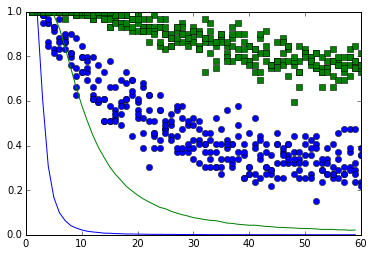

In [25]:
plt.plot(n_clusters, sessions_one_majority, 'bo',
         n_clusters, sessions_two_majority, 'gs',
         data_random['k'], data_random['prob_one'], 'b-',
         data_random['k'], data_random['prob_two'], 'g-')

In [ ]:
print fit_damop(joblib.load('cluster-atom-ph.pkl') )

(0.6779661016949152, 0.9661016949152542)


Fix the cluster size at 20. How many n_init do we need before the quality saturates?

In [10]:
# 100 iterations takes roughly 45 min, though I'm not completely sure.
sessions_one_majority_20_init = []
sessions_two_majority_20_init = []
n_init = range(0, 101, 10)
# n_init = range(0, 41, 20)
n_init[0] = 1
for n in n_init:
    print n
    clf = kmeans(20, n_init=n)
    tmp = fit_damop(clf)
    sessions_one_majority_20_init.append(tmp[0])
    sessions_two_majority_20_init.appendd(tmp[1])

1
21.2941308022
10
91.6313071251
20
185.891851902
30
312.140403032
40
388.701546907
50
499.028443098
60
578.055378914
70
827.387203932
80
928.070310116
90
1044.52200389
100
1082.5818181


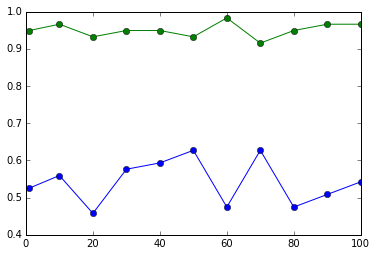

In [80]:
plt.plot(n_init, sessions_one_majority_20_init, 'bo-',
         n_init, sessions_two_majority_20_init, 'go-',)
#          n_init, sessions_one_majority_40_init, 'bs-',
#          n_init, sessions_two_majority_40_init, 'gs-')
# plt.plot(n_init, sessions_one_majority_20_init, 'bo-',
#          n_init, sessions_two_majority_20_init, 'go-',
#          n_init, sessions_one_majority_40_init, 'bs-',
#          n_init, sessions_two_majority_40_init, 'gs-')

In [15]:
with open("cluster-number-n_init.json", "w") as f:
    json.dump({'n_init': n_init,
               'sessions_one_majority_20': sessions_one_majority_20_init,
               'sessions_two_majority_20': sessions_two_majority_20_init,
              },
              f)
# with open("cluster-number-n_init.json", "w") as f:
#     json.dump({'n_init': n_init,
#                'sessions_one_majority_20': sessions_one_majority_20_init,
#                'sessions_two_majority_20': sessions_two_majority_20_init,
#                'sessions_one_majority_40': sessions_one_majority_40_init,
#                'sessions_two_majority_40': sessions_two_majority_40_init,},
#               f)

#### The hypothesis I'm testing above is that a "better" cluster (one that minimizes kmeans) will provide capture more groups of DAMOP sessions.
This can be tested by comparing each single optimization of the kmeans algorithm with how well it classifies DAMOP sessions. This should be computationally more efficient than varying n_init.

In [ ]:
def kmeans2(n_clusters, n_init=5):
    # 20 is good
    # n_clusters = 20
    # n_clusters = 20
    # Reduce n_init to 10 for testing purposes.
    clf_unsupervised = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), stop_words='english')),
                                 ('tfidf', TfidfTransformer()),
                                 ('clf', KMeans(n_clusters=n_clusters, n_init=n_init, n_jobs=-1))])
    start = time.time()
    clf_unsupervised.fit(x_train)
    print time.time() - start

#     start = time.time()
    predict_train = clf_unsupervised.predict(x_train)
    predict = clf_unsupervised.predict(x_test)
#     print time.time() - start
    return clf_unsupervised

In [67]:
# 100 iterations takes roughly 45 min, though I'm not completely sure.
sessions_one_majority_init = []
sessions_two_majority_init = []
inertia = []
for x in range(100):
    clf = kmeans(20, n_init=1)
    tmp = fit_damop(clf)
    sessions_one_majority_init.append(tmp[0])
    sessions_two_majority_init.append(tmp[1])
    inertia.append(clf.named_steps['clf'].inertia_)
    print (sessions_one_majority_init[-1], inertia[-1])

37.2615389824
(0.6779661016949152, 7224.8722622031355)
41.0532689095
(0.5254237288135594, 7217.353193125442)
32.0016860962
(0.559322033898305, 7219.854325557653)
33.8938159943
(0.5084745762711864, 7218.87764060321)
38.6301591396
(0.6271186440677966, 7217.571120486968)
22.1017889977
(0.5423728813559322, 7224.00417175552)
24.4936408997
(0.559322033898305, 7223.2470313215645)
27.6297149658
(0.5932203389830508, 7218.880158868093)
24.4499270916
(0.4915254237288136, 7218.96613246438)
23.5121700764
(0.576271186440678, 7223.1482397654745)
25.7452487946
(0.4576271186440678, 7221.988623233081)
30.1751101017
(0.4915254237288136, 7224.800157779746)
23.9272618294
(0.5423728813559322, 7220.5894805795015)
44.4353170395
(0.5084745762711864, 7221.34596159428)
30.1753339767
(0.559322033898305, 7225.820444592092)
25.3479781151
(0.5423728813559322, 7224.87871483471)
39.7576389313
(0.4576271186440678, 7220.14802066281)
37.910736084
(0.4576271186440678, 7217.198547204926)
22.4615681171
(0.4915254237288136, 

(0, 1)

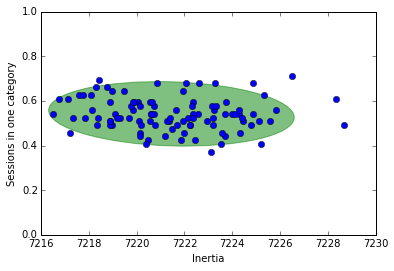

In [68]:
import error_ellipse
plt.plot(inertia, sessions_one_majority_init, 'o')
error_ellipse.plot_point_cov(np.array([inertia, sessions_one_majority_init]).T,
                             nstd=2,
                             alpha=0.5,
                             color='green')
plt.xlabel('Inertia')
plt.ylabel('Sessions in one category')
# plt.xlim([0, max(inertia)*2])
plt.ylim([0, 1])
# plt.xlim()

In [69]:
with open("cluster-number-inertia.json", "w") as f:
    json.dump({'inertia': inertia,
               'sessions_one_majority_init': sessions_one_majority_init,
               'sessions_two_majority_init': sessions_two_majority_init,
              },
              f)
# with open("cluster-number-n_init.json", "w") as f:
#     json.dump({'n_init': n_init,
#                'sessions_one_majority_20': sessions_one_majority_20_init,
#                'sessions_two_majority_20': sessions_two_majority_20_init,
#                'sessions_one_majority_40': sessions_one_majority_40_init,
#                'sessions_two_majority_40': sessions_two_majority_40_init,},
#               f)